# Multiprocessor Drum Synthesis
#### ECE 5760, Spring 2022, Adams/Land

In [773]:
from scipy.io import wavfile
from IPython.display import Audio
import numpy
from scipy.fft import fft
from scipy.signal import welch
import matplotlib.pyplot as plt
from IPython.display import HTML
plt.rcParams["figure.figsize"] = (20,3)
%matplotlib inline

samplerate, data = wavfile.read('./Fifty.wav')
samplerate2, data2 = wavfile.read('./Recording.wav')
samplerate3, data3 = wavfile.read('./100.wav')
samplerate_nonlinear, data_nonlinear = wavfile.read('./170_yes_nonlinear.wav')
samplerate_linear, data_linear = wavfile.read('./170_no_nonlinear.wav')

In [774]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

***
## Introduction

In this lab, you are challenged to use the hardware resources on the FPGA as wisely as you can to accelerate a simulation of the 2D wave equation on a square mesh. The amplitude of the center node in the mesh will be communicated to the DAC at 48kHz to produce drum-like sounds. Your simulation will include a [nonlinear effect](./nonlinear.pdf) related to the instantaneous tension in the mesh that produces the pitch-glide heard in real drums.

You are challenged to simulate the largest drum that you can. The group that uses the DSP blocks and memory blocks on the FPGA most exhaustively (as few as possible left over) and efficiently (as many as possible being used in parallel) will be able to produce the largest drum. Last year, the winning group's drum contained over 88,000 nodes!

You will be asked to compare the sizes of the largest drums that you can simulate using only the HPS vs. the FPGA. This lab will give you a sense of the FPGA's power for *hardware acceleration.*

***
## Mathematical Background

A *wave equation* relates time derivatives to spatial derivates. The continuous form of the 2D wave equation is given below, where $c$ is the speed of sound and $u$ is the out-of-plane amplitude of the node.

\begin{align}
\frac{1}{c^2} \frac{\partial^2{u}}{\partial{t}^2} = \frac{\partial^2{u}}{\partial{x^2}} + \frac{\partial^2{u}}{\partial{y^2}} - \eta \frac{\partial{u}}{\partial{t}}
\end{align}

In order to implement this equation on the FPGA, we will used the *discretized version* shown below. For a derivation of the below equation from the above equation, see [this webpage](./Disretization.html). The amplitude of a particular node, $u_{i,j}$ at the next timestep, $n+1$, is a function of the node's amplitude at the current and previous timesteps ($n$ and $n-1$) and the amplitudes of the four adjacent nodes at the current timestep.

\begin{align}
u_{i,j}^{n+1} = \left[1 + \frac{\eta \Delta t}{2}\right]^{-1}\left\{ \rho_{eff}\left[ u_{i+1,j}^n + u_{i-1,j}^n + u_{i,j-1}^n + u_{i,j+1}^n - 4u_{i,j}^n\right] + 2u_{i,j}^n - \left[1 - \frac{\eta \Delta t}{2}\right]u_{i,j}^{n-1}\right\}
\end{align}

(Take a close look at that first term. If $\frac{\eta \Delta t}{2}$ is small, is there an opportunity for simplification?) All of the other terms in the above expression are constants, except for $\rho_{eff}$. The value for this term is nonlinearly related to the amplitude of the center node according to the equation given below. This nonlinear coupling generates an audible "pitch-glide" just like is heard in real drums. In order for the drum to be stable, this value *must* be less than 0.5.

\begin{align}
\rho_{eff} = \text{min}\left(0.49, \rho_0 +[u_{center} \cdot G_{tension}]^2\right)
\end{align}

Reasonable values for the other parameters might be

\begin{align}
\rho_0 &\approx 0.25\\
G_{tension} &\approx 2^{-3} \rightarrow 2^{-5}\\
\frac{\eta \Delta t}{2}&\approx 2^{-9} \rightarrow 2^{-10}
\end{align}

***
## Resources and reading

#### Previous years' lectures
> - [2020 - Lecture 8-16](https://www.youtube.com/playlist?list=PLDqMkB5cbBA4OW0fDTu1FY6aw4uBWOpBa)
> - [2017 - Lectures 13-17](https://www.youtube.com/playlist?list=PLKcjQ_UFkrd7UcOVMm39A6VdMbWWq-e_c)

#### The 2D wave equation
> - [Hunter's write up on discretization of the 2D wave equation](./Discretization.html)
> - [*Study Notes on Numerical Solutions of the Wave Equation with the Finite Difference Method*](./Wave.pdf) - **we are simulating equation 2.18.**
> - [*Physical Modeling with the 2-D Digital Waveguide Mesh*](./2Dmesh.pdf)


#### Parallelizing the 2D wave equation
> - [**Hunter's slides** (link required)]
> - [*Implementation of finite difference schemes for the wave equation on FPGA*](./FPGAfd.pdf)
> - [*Parallel implementation of finite difference schemes for the plate equation on a FPGA-based multi-processor array*](./FPGAparallel.pdf)
> - [*Time domain numerical simulation for transient waves on reconfigurable coprocessor platform*](./td.pdf)
> - [*Design methodology for real-time FPGA-based sound synthesis*](./design.pdf)

#### The audio interface
> - [Wolfson WM8731 audio CODEC datasheet](./Wolfson.pdf)
> > - The Qsys [AV config module](./AVconfig_dialog.PNG) abstracts away much of the codec detail
> > - The codec fast data transfer hardware is hidden behind Altera IP called the [University Audio Core](./Audio_core.pdf) for Qsys ([configuration interface](./Auido_dialog.PNG)).
> > - An example using the audio core is near the bottom of the [Avalon Bus master](https://people.ece.cornell.edu/land/courses/ece5760/DE1_SOC/HPS_peripherials/Bus_master_slave_index.html) page.

#### FPGA hardware
> - [Cyclone V Handbook](./cyclone5_handbook.pdf)
> - [Summary of hardware](./CycloneV_SE_A5.PNG)
> - [DSP blocks description](./dsp.pdf)
> - [Arithmetic megafunctions](./ug_lpm_alt_mfug.pdf)
> - [HDL style - inferring memory and DSP blocks](./hdl.pdf)

#### Generate statements
> - [Evans and Sutherland HDL guide](https://sutherland-hdl.com/pdfs/verilog_2001_ref_guide.pdf), chapter 9
> - [**Hunter's write-up** (link required)]
> - [Generate Blocks (Springer)](https://link.springer.com/content/pdf/10.1007/978-1-4615-1713-9_38.pdf)
> - [Verilog Pro site](https://www.verilogpro.com/verilog-generate-configurable-rtl/)
> - [System Verilog Generate Construct](https://www.systemverilog.io/generate)

#### Some sample code
> - [Matlab program](https://people.ece.cornell.edu/land/courses/ece5760/LABS/s2019/FDfreeEdge2order.m) from Bruce gives a sequential version of the algorithm and plots the Fourier modes of the drum.
> - Clicking "show code" at the top of this webpage will reveal Python code by Hunter based on Bruce's Matlab code (for the more Pythonically inclined person). Like the Matlab, it gives a sequential version of the algorithm and plots the Fourier modes of the drum. Plots given below. It compares the simulated and theoretical drum modes, as given in [*Physical Modeling with the 2-D Digital Waveguide Mesh*](./2Dmesh.pdf).
> - [Bruce's HPS code](http://people.ece.cornell.edu/land/courses/ece5760/DE1_SOC/DE1_soc_computer/Audio_video/media_brl4_7_audio_drum.c) which implements the above equation in C for realtime synthesis on the HPS
> - If you play with the boundary conditions, damping, wave speed, drum size, and initial conditions, the sound will be drum-like, chime-like, gong-like, or bell-like.

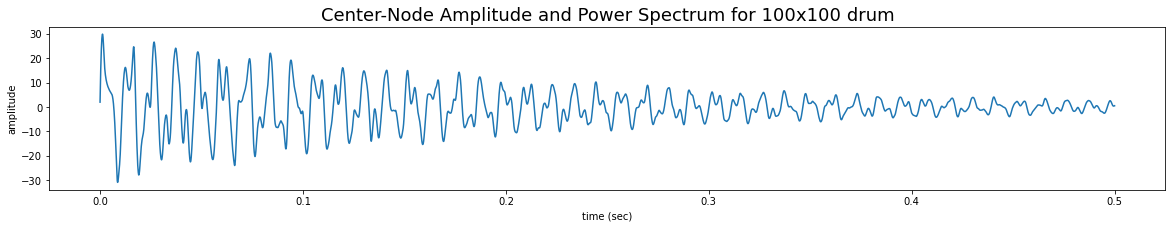

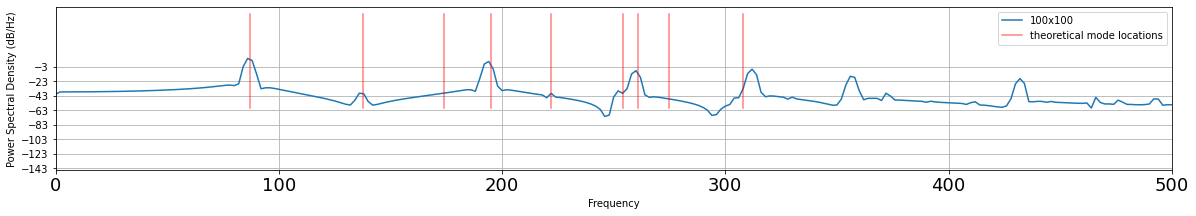

Audio - Python synthesized, 100x100 drum


In [1316]:
# Initializize drum
n = 100 ;
u = numpy.zeros((n,n)); 
u1 = numpy.zeros((n,n)); 
u2 = numpy.zeros((n,n)); 
uHit = numpy.zeros((n,n)); 

# Set rho, sample rate, and simulation time
rho = 1./16;
Fs = 48000 ;
time = numpy.arange(0, 0.5, (1./Fs))

# Array in which to store audio samples
aud = numpy.zeros(len(time)) ;

# Compute middle nodes
x_mid = int(n/2.);
y_mid = int(n/2.);

# Initialize drum amplitudes to a pyramid
for i in range(1, n-1):
    for j in range(1,n-1):
        uHit[i,j] = max(0, 30-(abs(x_mid - i) + abs(y_mid - j)))/30.;

# Zero boundary conditions
uHit[0,:] = 0
uHit[n-1,:] = 0
uHit[:,0] = 0
uHit[:,n-1] = 0

# Indexing variable
tindex = 0;

# Loop through time array
for t in time:
    
    u = numpy.zeros((n,n))
    
    # Hit the drum at t=0
    if (t==0): 
        u1 = u1 + uHit;
    
    # Compute updated drum amplitudes
    u[1:n-2,1:n-2] = (1./(1+.0001)) * (rho * (u1[2:n-1,1:n-2]+
                                      u1[0:n-3,1:n-2]+
                                      u1[1:n-2,2:n-1]+
                                      u1[1:n-2,0:n-3]-
                                      4*u1[1:n-2,1:n-2])
                               + 2*u1[1:n-2,1:n-2]
                               - (1-.0001) * (u2[1:n-2,1:n-2]) ) ;

    # Amplitude of center node goes into audio array
    aud[tindex] = u[n//2,n//2] ; 
    
    # Update/store drum state
    u2 = u1;
    u1 = u;
    
    # Iterate
    tindex = tindex + 1;    


# Plot the center node amplitudes
plt.plot(time, aud)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.title('Center-Node Amplitude and Power Spectrum for 100x100 drum', fontsize=18)
plt.figsize=(20,3)
plt.show()

# Plot the power spectrum
plt.rcParams["figure.figsize"] = (20,3)
Pxxt, freqst = plt.psd(aud,
                     NFFT=len(aud),
                     Fs=48000,
                     window=numpy.hamming(len(aud)),
                     noverlap=50, label='100x100')

# Plot the theoretical mode locations
fundamental = 87
yvals = numpy.linspace(-60, 70)
modes = [1.58, 2.0, 2.24, 2.55, 2.92, 3.0, 3.16, 3.54]
plt.plot(numpy.ones(len(yvals))*fundamental,
             yvals,
             'red',
             alpha=0.5, label='theoretical mode locations')
for i in modes:
    plt.plot(numpy.ones(len(yvals))*fundamental*i,
             yvals,
             'red',
             alpha=0.5)
    
# Configure plots
plt.xlim([0,500])
plt.xticks(size=18)
plt.legend(loc='best')
plt.show()

# Output audio
print("Audio - Python synthesized, 100x100 drum")
Audio(aud, rate=48000)

#### Examples of FPGA-synthesized drums

Sound from a 170x50 drum

In [1271]:
drum = numpy.array([float(i[1]+i[0])/2. for i in data[110000:160000]])
drum = drum - numpy.mean(drum)
Audio(drum, rate=samplerate)

Sound from a 170x100 drum

In [756]:
drum3 = numpy.array([float(i[1]+i[0])/2. for i in data3[120000:180000]])
drum3 = drum3 - numpy.mean(drum3)
Audio(drum3, rate=samplerate3)

Sound from a linear drum (170x170)

In [754]:
drum_linear = numpy.array([float(i[1]+i[0])/2. for i in data_linear[100000:160000]])
drum_linear = drum_linear - numpy.mean(drum_linear)
Audio(drum_linear, rate=samplerate_linear)

Sound from a nonlinear drum (170x170)

In [1278]:
drum_nonlinear = numpy.array([float(i[1]+i[0])/2. for i in data_nonlinear[105000:160000]])
drum_nonlinear = drum_nonlinear - numpy.mean(drum_nonlinear)
Audio(drum_nonlinear, rate=samplerate_nonlinear)

***
## Procedure and Weekly Checkpoints


### Week One
1. Search for *Audio Synthesis* on the [DSP page](https://people.ece.cornell.edu/land/courses/ece5760/DE1_SOC/HPS_peripherials/DSP_index.html)
> - Get the linear 2D PDE drum synthesis HPS code running (available on the DSP page, and also linked [here](https://people.ece.cornell.edu/land/courses/ece5760/DE1_SOC/DSP/Audio/Synthesis/Improved_string/media_brl4_7_audio_drum.c)
> - **The above HPS code will help you write your Verilog.**
> - Modify the code for athe nonlinear rho effect
> -  Scale up the HPS solution until it is no longer realtime
1. Use synthesizable Verilog running in ModelSim to simulate a single node with zero boundary conditions.
<figure>
    <img align="center" width="500" height="500" src="one.png" alt='missing' />
    <center><figcaption>Single node, zero boundary conditions</figcaption></center>
</figure>

> - The result should be simple harmonic motion
> - Remember that rho<0.5. Start with rho=1/16.
> - Note that when rho is close to the limit of 0.5, the solution has a *very high natural frequency*, so the sine wave will be on the border of aliasing and thus look like a square wave.
> - Assuming 1.17 fixed point, start with initial conditions $u^n = u^{n-1}$ and an amplitude of about 1/8 full scale
<figure>
    <img align="center" width="1500" height="500" src="one_node_2.png" alt='missing' />
    <center><figcaption></figcaption></center>
</figure>
<figure>
    <img align="center" width="1500" height="500" src="one_node_1.png" alt='missing' />
    <center><figcaption>ModelSim output for a single node with zero boundary conditions</figcaption></center>
</figure><br><br>

2. Use synthesizable Verilog running in ModelSim to simulate a single *column of nodes* of length ~30 and with zero boundary conditions on the edges and on either end.
<figure>
    <img align="center" width="60" height="500" src="colgraphic.png" alt='missing' />
    <center><figcaption>Column of nodes</figcaption></center>
</figure>

> - Store the initial amplitudes for the $n$ and $n-1$ timesteps in M10k memory blocks.
> - Create a state machine that reads a node amplitudes from M10k memory, computes their updated amplitudes, and writes those updated amplitudes back to M10k memory. The state machine will start at the bottom of the column and move to the top.
> - Remember that node updates *must be synchronous.* Otherwise your drum will be unconditionally unstable.
> - Initialize the node amplitudes in a triangle shape (highest in the middle, linearly falling to zero at the ends). View the node amplitudes in ModelSim. You should see the node amplitudes oscillate back and forth, with their amplitudes decaying over time.

<figure>
    <img align="center" width="1500" height="500" src="column.png" alt='missing' />
    <center><figcaption>Column of nodes oscillating</figcaption></center>
</figure>
<figure>
    <img align="center" width="1500" height="500" src="column2.png" alt='missing' />
    <center><figcaption>Column of nodes oscillating with decayed amplitude at later time</figcaption></center>
</figure><br><br>

***
###  Week Two

1. Using a generate statement, instantiate and connect 30 node columns. This will create a 30x30 drum for which all columns are update in parallel, and each row is updated in series.
<figure>
    <img align="center" width="500" height="500" src="rowcol.png" alt='missing' />
    <center><figcaption>30x30 drum. Columns updated in parallel, rows updated in series</figcaption></center>
</figure><br><br>

2. Give all nodes reasonable initial conditions. Remember that you **cannot** just give the center node nonzero amplitude (spatial aliasing will occur). Your drum must be initialized with amplitudes that relatively smoothly transition from high in the center to zero at the boundaries. A pyramid works just fine.

3. Output the amplitude of the *center node* in ModelSim. It will look something like that shown below.<br><br>
<figure>
    <img align="center" width="1000" height="500" src="thirty.png" alt='missing' />
    <center><figcaption>Amplitude of center node for 30x30 drum</figcaption></center>
</figure><br><br>

4. Export these data and play the sound that they generate with Matlab or Python. It should sound vaguely like a cowbell or a woodblock.

5. Add the nonlinear rho calculation to your ModelSim simulation.

6. Add synchronization signals to your ModelSim simulation.

7. Add computation time to your ModelSim simulation.

7. Download the *Audio output bus_master* example from the [Bus Master webpage](https://people.ece.cornell.edu/land/courses/ece5760/DE1_SOC/HPS_peripherials/Bus_master_slave_index.html).
> - This example performs direct digital synthesis of a sine wave, with frequency controlled by the switches
> - Get it running and listen to it.

***
### Week Three

1. Integrate your drum synthesizer into the *Audio output bus_master* example from the [Bus Master webpage](https://people.ece.cornell.edu/land/courses/ece5760/DE1_SOC/HPS_peripherials/Bus_master_slave_index.html).
> - Use hardcoded parameters
> - Use a 30x30 drum
> - Compile time will be approximately 9 minutes
> - Should sound like a cowbell or woodblock
> - Look at the compilation report to confirm that your multiplier usage is what you expect for it to be
2. With the 30-column drum, make the number of rows, the rho gain, and the initial amplitude of the drum configurable via PIO ports and/or the onboard switches and buttons.
> - Compile and test, compile time will be about 9 minutes
3. Scale up! Add as many columns to the drum as you can, making sure that you don't exceed 174 multipliers.
> - Your grid should have no more than 4:1 aspect ratio
> - Grid expansion via symmetry does not count for size
> - Compile time will be >20 minutes
> - Through your user interface (either PIO or switches) increase the number of rows in the drum until you can no longer meet timing requirements.
> - Listen to the drum with headphones that have nice bass, or through a subwoofer
> - Look for opportunities to optimize (pipeline your drum simulator? add a faster PLL to achieve more rows?)
4. In your demonstration, you will be asked to
> - Demonstrate the largest drum that you can simulate in realtime (no more than 4:1 aspect ratio)
> - Demonstrate at least three different drum sounds
> - At least one sound must include audible nonlinear tension modulation effects
> - Prove that the computation finishes in less than 20.8 $\mu s$ for your drums

***
## Lab Report
Your lab report should contain
1. The sections mentioned in the [policy page](https://people.ece.cornell.edu/land/courses/ece5760/policy.html)
2. Mathematical considerations (what you actually implemented)
2. A table of grid size vs. compute time for both the FPGA solver and the HPS solver
> - Do you see any cache-size effects on HPS? What is the effect of -O0 vs. -O3?
> - Are there any scaling surprises in the FPGA?
3. A description of your parallelization scheme
4. A plot of the power spectrum of your drum sounds for a few different drum sizes (example shown below)
4. A screenshot from the chip planner for your biggest drum, showing hardware utilization
5. A heavily commented listing of your Verilog and GCC code.

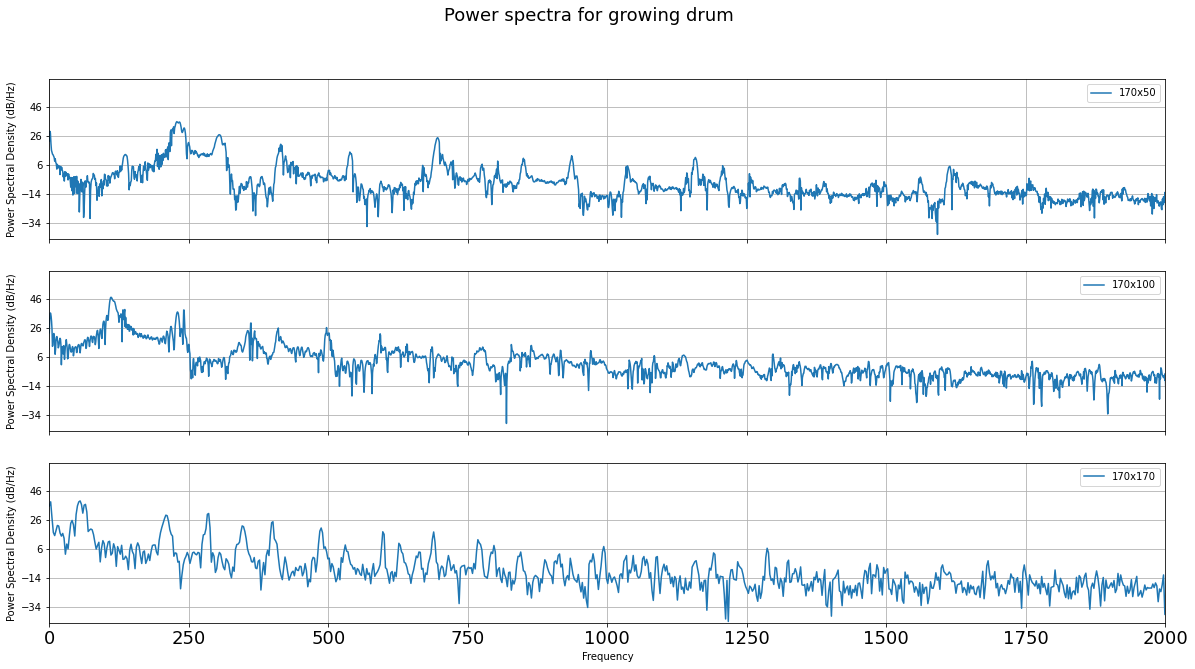

In [1241]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(20,10))

Pxx3, freqs3, line = axs[1].psd(drum3,
                     NFFT=len(drum3),
                     Fs=samplerate3,
                     window=numpy.hamming(len(drum3)),
                     noverlap=50, label='170x100', return_line=True)
axs[1].legend(loc='best')
axs[1].set(xlabel='', visible='False')

Pxx, freqs, line = axs[0].psd(drum,
                     NFFT=len(drum),
                     Fs=samplerate,
                     window=numpy.hamming(len(drum)),
                     noverlap=50, label='170x50', return_line=True)
axs[0].legend(loc='best')
axs[0].set(xlabel='', visible='False')

Pxx2, freqs2, line2 = axs[2].psd(drum2[30000:50000],
                     NFFT=len(drum2[30000:50000]),
                     Fs=samplerate2,
                     window=numpy.hamming(len(drum2[30000:50000])),
                     noverlap=50, label='170x170', return_line=True)




# fundamental = 210
# yvals = numpy.linspace(-60, 70)
# modes = [1.58, 2.0, 2.24, 2.55, 2.92, 3.0]
# axs[2].plot(numpy.ones(len(yvals))*fundamental,
#              yvals,
#              'red',
#              alpha=0.5, label='theoretical mode locations')
# for i in modes:
#     axs[2].plot(numpy.ones(len(yvals))*fundamental*i,
#              yvals,
#              'red',
#              alpha=0.5)

axs[2].legend(loc='best')
    
plt.ylim([-45, 65])
plt.xlim([0, 2000])
fig.suptitle('Power spectra for growing drum', fontsize='18')
plt.xticks(size=18)

plt.show()

***
***
***

***
***
***